In [1]:
# 🌾 AI Hackathon Notebook: AI Credit Scoring for Smallholder Farmers
# ---------------------------------------------------------------
# This notebook integrates the harmonized dataset, computes risk factors
# based on weighted metrics, validates consistency, and trains a predictive model.

# ================================================================
# 📦 IMPORTS
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pickle, gzip


In [2]:
# ================================================================
# 📂 LOAD DATASET
# ================================================================
df = pd.read_csv("main_harmonized_dataset_final.csv")
print(f"Dataset loaded with {df.shape[0]} records and {df.shape[1]} columns.")

Dataset loaded with 2000 records and 28 columns.


In [3]:
# ================================================================
# 🧮 NORMALIZATION FUNCTIONS (from Risk Factor Word Document)
# ================================================================
def normalize_aez(x):
    return {"High": 0, "Moderate": 0.5, "Low": 1}.get(x, np.nan)

def normalize_pest(x):
    return {"Low": 0, "Moderate": 0.5, "High": 1}.get(x, np.nan)

def normalize_water(x):
    return {"High": 0, "Moderate": 0.5, "Low": 1}.get(x, np.nan)

def normalize_storage(x):
    return {"Yes": 0, "No": 1}.get(x, np.nan)

def normalize_market(x):
    return {"Yes": 0, "No": 1}.get(x, np.nan)

def normalize_planting(x):
    return {"High": 0, "Low": 1}.get(x, np.nan)

def normalize_experience(x):
    mapping = {">9 years": 0, "5-9 years": 0.25, "1-4 years": 0.5, "<1 year": 1}
    return mapping.get(x, np.nan)

def normalize_coop(x):
    return {"Yes": 0, "No": 1}.get(x, np.nan)

def normalize_input(x):
    return {"Yes": 0, "No": 1}.get(x, np.nan)



In [4]:
# ================================================================
# ⚙️ COMPUTE WEIGHTED RISK FACTOR
# ================================================================
df["Computed_Risk_Factor"] = (
    0.18 * df["Agro-Ecological Zone Compatibility"].map(normalize_aez) +
    0.17 * df["Pest disease vulnerability"].map(normalize_pest) +
    0.14 * df["Water irrigation reliability"].map(normalize_water) +
    0.13 * df["Post Harvest Storage"].map(normalize_storage) +
    0.13 * df["Market Access"].map(normalize_market) +
    0.10 * df["Planting/Sowing Time"].map(normalize_planting) +
    0.08 * df["Farmer experience"].map(normalize_experience) +
    0.05 * df["Cooperative Membership"].map(normalize_coop) +
    0.02 * df["Input Access and Affordability"].map(normalize_input)
).round(3)

In [5]:
# ================================================================
# 🧩 VALIDATE EXISTING RISK FACTOR
# ================================================================
tolerance = 0.02
if "Risk Factor" in df.columns:
    similarity = np.mean(np.isclose(df["Risk Factor"], df["Computed_Risk_Factor"], atol=tolerance))
    print(f"Similarity with existing Risk Factor: {similarity*100:.1f}%")

    if similarity < 0.95:
        print("⚠️ Significant difference found — overwriting 'Risk Factor'.")
        df["Risk Factor"] = df["Computed_Risk_Factor"]
    else:
        print("✅ Existing Risk Factor consistent — keeping original values.")
else:
    print("🆕 No 'Risk Factor' column found — creating one.")
    df["Risk Factor"] = df["Computed_Risk_Factor"]

Similarity with existing Risk Factor: 89.8%
⚠️ Significant difference found — overwriting 'Risk Factor'.


In [6]:
# ================================================================
# 🎯 CREATE BINARY TARGET
# ================================================================
df["default"] = (df["Risk Factor"] > 0.5).astype(int)
print(df[["Risk Factor", "default"]].head())

   Risk Factor  default
0        0.330        0
1        0.520        1
2        0.270        0
3        0.610        1
4        0.445        0


In [7]:
# ================================================================
# 🧹 FEATURE SELECTION
# ================================================================
features = [
    'Agro-Ecological Zone Compatibility', 'Pest disease vulnerability',
    'Water irrigation reliability', 'Post Harvest Storage', 'Market Access',
    'Planting/Sowing Time', 'Farmer experience', 'Cooperative Membership',
    'Input Access and Affordability', 'Crop Type', 'Gender', 'Farm size',
    'Previous Yield Output (Kgs)', 'Age'
]

X = df[features]
y = df["default"]

In [8]:
# ================================================================
# 🔄 PREPROCESSING PIPELINE
# ================================================================
num_features = ['Farm size', 'Previous Yield Output (Kgs)', 'Age']
cat_features = [f for f in X.columns if f not in num_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [9]:
# ================================================================
# 🧠 MODEL TRAINING
# ================================================================
model = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Farm size',
                                                   'Previous Yield Output '
                                                   '(Kgs)',
                                                   'Age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Agro-Ecological Zone '
                                                   'Compatibility',
                                                   'Pest disease vulnerability',
                                                   'Water irrigation '
                                                   'reliability',
                                                   'Post Harvest Storage',
                                                   'Market Access',
                                                   'Planting/Sowing Time',
                                                   'Farmer experience',
                                                   'Cooperative Membership',
                                                   'Input Access and '
                                                   'Affordability',
                                                   'Crop Type', 'Gender'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       328
           1       0.96      0.72      0.83        72

    accuracy                           0.94       400
   macro avg       0.95      0.86      0.90       400
weighted avg       0.95      0.94      0.94       400

ROC AUC Score: 0.9844


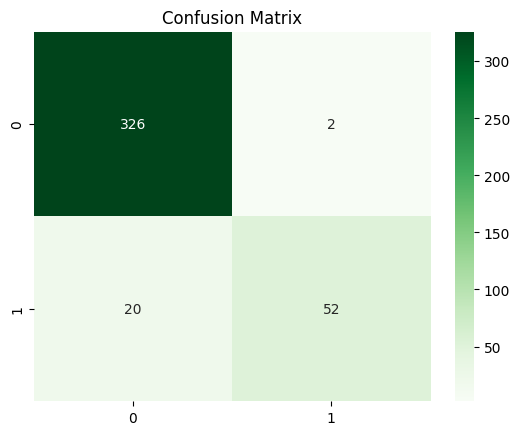

In [10]:
# ================================================================
# 📊 EVALUATION
# ================================================================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# ================================================================
# 💾 SAVE MODEL
# ================================================================
with gzip.open("credit_model.pkl.gz", "wb") as f:
    pickle.dump(model, f)

print("✅ Model trained and saved as 'credit_model.pkl.gz'")

✅ Model trained and saved as 'credit_model.pkl.gz'
